In [1]:
import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import utile_labels

import keras_ocr

tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

tf.config.list_physical_devices('GPU')

# tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
dataset_labels = utile_labels.get_labels_tot_and_noise()[:-300]
print("Dataset len:", len(dataset_labels))
dataset_labels[:2]

Dataset len: 23418


[('image_dataset_noise/noise_gauss_img_10.png', None, 'am'),
 ('image_dataset_noise/noise_median_img_10.png', None, 'am')]

In [4]:
test_labels =  utile_labels.get_labels_tot_and_noise()[23518:]
print("Test len:", len(test_labels))
test_labels[:2]

Test len: 200


[('image_dataset/img_9746.png', None, 'michela'),
 ('image_dataset/img_9747.png', None, 'tessera')]

In [5]:
# recognizer_alphabet = recognizer.alphabet
# recognizer_alphabet = recognizer_alphabet[:12] + './-()'+recognizer_alphabet[12:]
# recognizer_alphabet
alphabet = ' 0123456789ab./-()cdefghijklmnopqrstuvwxyz'
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
recognizer_alphabet

' ()-./0123456789abcdefghijklmnopqrstuvwxyz'

In [6]:
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()

Instructions for updating:
Colocations handled automatically by placer.
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Computer\.keras-ocr\crnn_kurapan_notop.h5


In [7]:
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(dataset_labels, test_size=0.2, random_state=42)

print("Train len:", len(train_labels))
print("Train example:", train_labels[:2])
print("Validation len", len(validation_labels))


Train len: 18734
Train example: [('image_dataset/img_6859.png', None, '13.07.1959'), ('image_dataset/img_5765.png', None, 'diresidenza')]
Validation len 4684


In [8]:
batch_size = 32

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer_alphabet,
            # augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]

In [9]:
print(training_image_gen, training_steps)
print(validation_image_gen, validation_steps)

<generator object get_recognizer_image_generator at 0x000002016953DF50> 585
<generator object get_recognizer_image_generator at 0x000002016953C350> 146


In [10]:
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: taranto


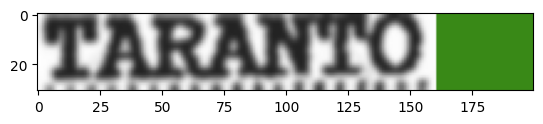

In [11]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

text: /surname


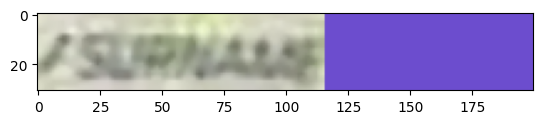

In [12]:
image, text = next(validation_image_gen)
print('text:', text)
_ = plt.imshow(image)

In [13]:
# RECOGNIZER LOAD_MODEL / FIT
# recognizer.model = tf.keras.models.load_model('modelli_allenati/recogn_model_colab_05')

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('checkpoints', monitor='val_loss', save_best_only=True, save_freq='epoch'),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=50,
)

Epoch 1/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 7.6071

c:\Users\Computer\anaconda3\envs\condomini-env\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 175s 286ms/step - batch: 292.0000 - size: 8.0000 - loss: 7.6071 - val_loss: 5.3641
Epoch 2/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 2.3708

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 165s 282ms/step - batch: 292.0000 - size: 8.0000 - loss: 2.3708 - val_loss: 2.5459
Epoch 3/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.9641

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 166s 284ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.9641 - val_loss: 1.4917
Epoch 4/50
585/585 [==============================] - 148s 253ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.6483 - val_loss: 1.6709
Epoch 5/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.2170

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 158s 271ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.2170 - val_loss: 1.3725
Epoch 6/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.1986

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 152s 260ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.1986 - val_loss: 1.2187
Epoch 7/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 1.0756

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 162s 276ms/step - batch: 292.0000 - size: 8.0000 - loss: 1.0756 - val_loss: 1.1795
Epoch 8/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.9104

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 165s 282ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.9104 - val_loss: 1.1325
Epoch 9/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.8711

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 167s 285ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.8711 - val_loss: 0.7551
Epoch 10/50
585/585 [==============================] - 154s 263ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.9160 - val_loss: 1.3545
Epoch 11/50
585/585 [==============================] - 155s 265ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.7760 - val_loss: 1.4049
Epoch 12/50
585/585 [==============================] - 149s 255ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.7005 - val_loss: 0.8317
Epoch 13/50
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.7146 - val_loss: 0.8240
Epoch 14/50
585/585 [==============================] - 142s 243ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.6885 - val_loss: 1.3721
Epoch 15/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.6293

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 156s 267ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.6293 - val_loss: 0.6790
Epoch 16/50
585/585 [==============================] - 141s 241ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.6064 - val_loss: 0.7799
Epoch 17/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.6196

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 163s 279ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.6196 - val_loss: 0.6504
Epoch 18/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.5701

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 167s 286ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.5701 - val_loss: 0.6417
Epoch 19/50
585/585 [==============================] - 150s 256ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4824 - val_loss: 0.6480
Epoch 20/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.4818

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 166s 284ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4818 - val_loss: 0.5263
Epoch 21/50
585/585 [==============================] - 153s 261ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4989 - val_loss: 0.6252
Epoch 22/50
585/585 [==============================] - 153s 261ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4042 - val_loss: 0.5495
Epoch 23/50
585/585 [==============================] - 145s 248ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4252 - val_loss: 0.5539
Epoch 24/50
585/585 [==============================] - 140s 238ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4459 - val_loss: 0.5683
Epoch 25/50
585/585 [==============================] - 138s 236ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4273 - val_loss: 0.5477
Epoch 26/50
585/585 [==============================] - 139s 237ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3663 - val_loss: 0.5866
Epoch 27/50
585/585 [=========================

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 161s 275ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4179 - val_loss: 0.4583
Epoch 28/50
585/585 [==============================] - 148s 253ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.4226 - val_loss: 0.8962
Epoch 29/50
585/585 [==============================] - 150s 256ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3687 - val_loss: 0.7233
Epoch 30/50
585/585 [==============================] - 151s 258ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3890 - val_loss: 1.1204
Epoch 31/50
585/585 [==============================] - 139s 237ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3677 - val_loss: 0.4722
Epoch 32/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.3178

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 154s 264ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3178 - val_loss: 0.4433
Epoch 33/50
585/585 [==============================] - 139s 237ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3071 - val_loss: 0.5657
Epoch 34/50
585/585 [==============================] - 148s 252ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3686 - val_loss: 0.4540
Epoch 35/50
585/585 [==============================] - 143s 245ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2976 - val_loss: 0.6224
Epoch 36/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.3290

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 158s 270ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3290 - val_loss: 0.4361
Epoch 37/50
585/585 [==============================] - 158s 270ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3321 - val_loss: 0.4432
Epoch 38/50
585/585 [==============================] - ETA: 0s - batch: 292.0000 - size: 8.0000 - loss: 0.2520

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


585/585 [==============================] - 163s 279ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2520 - val_loss: 0.3288
Epoch 39/50
585/585 [==============================] - 145s 248ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3174 - val_loss: 0.4514
Epoch 40/50
585/585 [==============================] - 147s 251ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2753 - val_loss: 0.5192
Epoch 41/50
585/585 [==============================] - 146s 250ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2496 - val_loss: 0.4041
Epoch 42/50
585/585 [==============================] - 152s 259ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3187 - val_loss: 0.6327
Epoch 43/50
585/585 [==============================] - 154s 263ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.3295 - val_loss: 0.4824
Epoch 44/50
585/585 [==============================] - 149s 254ms/step - batch: 292.0000 - size: 8.0000 - loss: 0.2915 - val_loss: 0.4989
Epoch 45/50
585/585 [=========================

In [17]:
# Save the weights
recognizer.model.save_weights('weights')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./weights')

# Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Predicted: sanitaria, Actual: sanitaria


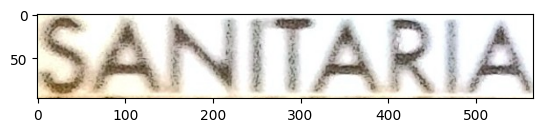

In [27]:
image_filepath, _, actual = test_labels[np.random.randint(0,  len(test_labels))]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [16]:
import cv2

Looking for C:\Users\Computer\.keras-ocr\craft_mlt_25k.h5


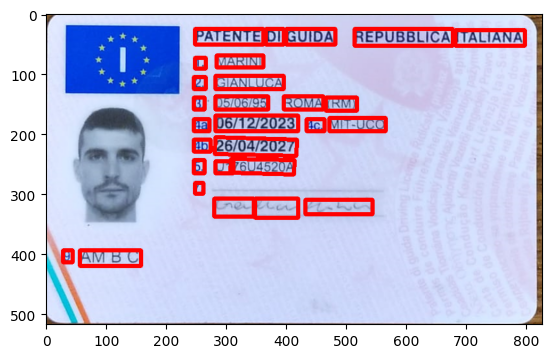

In [32]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
pathFile = 'documenti_test/patente.png'
# Original Image -> label Detector

image_original = keras_ocr.tools.read(pathFile)

boxes_orignial = detector.detect(images=[image_original])[0]

drawn = keras_ocr.tools.drawBoxes(image=image_original, boxes=boxes_orignial)

plt.imshow(drawn)

In [33]:
array = []
for idx,box in enumerate(boxes_orignial) :
    # Trasforma array in INT
    box = box.astype('int64')
    # Ritaglia bounding-box corrente da immagine...
    parola_cropped = image_original[box[0][1]:box[2][1], box[0][0]:box[2][0] ]
    cv2.imwrite("temp.png", parola_cropped)
    img_cropped = cv2.imread('temp.png')
    array.append(recognizer.recognize(img_cropped))
print(array)

['patente', 'di', 'guida', 'repubblica', 'italiana', 'marini', '1.', 'gianluca', '2.', '05/06/95', 'roma', '3.', '(rme', '06/12/2023', 'mit-uco', '4a', '4c.', '26/04/2027', '4b.', '5.', '76u4520a', 'u1', '7.', 'cau', 'fcc', '/turucn', '9.', 'ambc']


In [34]:
recognizer2 = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer2.model = tf.keras.models.load_model('checkpoints')
recognizer2.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\Computer\.keras-ocr\crnn_kurapan_notop.h5


SystemError: unknown opcode

In [ ]:
array = []
for idx,box in enumerate(boxes_orignial) :
    # Trasforma array in INT
    box = box.astype('int64')
    # Ritaglia bounding-box corrente da immagine...
    parola_cropped = image_original[box[0][1]:box[2][1], box[0][0]:box[2][0] ]
    cv2.imwrite("temp.png", parola_cropped)
    img_cropped = cv2.imread('temp.png')
    array.append(recognizer2.recognize(img_cropped))
print(array)

In [35]:
recognizer.model.save('modelli_allenati/recognizer_model')

INFO:tensorflow:Assets written to: modelli_allenati/recognizer_model\assets


INFO:tensorflow:Assets written to: modelli_allenati/recognizer_model\assets


In [37]:
tf.keras.models.load_model('modelli_allenati/recognizer_model')

SystemError: unknown opcode